In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [17]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import pandas as pd
import nltk
import cv2
import os
import string
import tensorflow as tf
from google.colab.patches import cv2_imshow
from glob import glob
from collections import Counter
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.engine.input_layer import Input
#from tensorflow.python.keras.utils import to_categorical
from nltk.stem import WordNetLemmatizer
from tensorflow.python.keras.models import Model, load_model
from wordcloud import WordCloud, STOPWORDS 
from tensorflow.python.keras.layers import GRU,Conv2D,MaxPooling2D,Conv2DTranspose,Dropout,concatenate,Activation
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import pickle
import itertools
import pdb
import tqdm
nltk.download('wordnet')

2.2.0-rc1
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
#Data read
#Data generator
#Model trainl

In [0]:
trainPath='/content/stage1_train'
testPath='/content/stage1_test'
def pathGeneration(trainPath,testPath):
  xTrain={}
  yTrain={}
  for idx,name in enumerate(os.listdir(trainPath)):
    xTrain[idx]=(trainPath+'/'+name+'/images/'+name+'.png')
    for mask_imgs in os.listdir(trainPath+'/'+name+'/masks'):
      if idx not in yTrain:
        yTrain[idx]=list()
      yTrain[idx].append(trainPath+'/'+name+'/masks/'+mask_imgs)
  return xTrain,yTrain
xTrain,yTrain=pathGeneration(trainPath,testPath)


In [0]:
len(xTrain)

670

In [14]:
def preProcess(img_path):
  channels=3
  img=imread(img_path)[:,:,:channels]
  dsize=(128,128)
  img=resize(img,dsize)
  imageExpand=np.expand_dims(img,axis=0)
  #plt.imshow(img)
  #plt.show()
  #print("img",img.shape)
  #print("iexpand",imageExpand.shape)
  return img

def maskFormation(folder_path):
  dsize=(128,128)
  mask=np.zeros((128,128,1),dtype=np.bool)
  for file in folder_path:
    img=imread(file)
    img=np.expand_dims(resize(img,dsize),axis=-1)
    mask=np.maximum(mask,img)
  maskExpand=np.expand_dims(mask,axis=0)
  #plt.imshow(np.squeeze(mask))
  #plt.show()
  
  #print("img",mask.shape)
  #print("iexpand",maskExpand.shape)
  return mask
    
preProcess(xTrain[19])
maskFormation(yTrain[19])  


array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [0]:
def dataGen(xTrain,yTrain,batchSize,epochs):
  for j in range(0,epochs):
    for i in range(0, len(xTrain)//batchSize):
      batchX=[]
      batchY=[]
      index=np.random.randint(0,len(xTrain),batchSize)
      for i in index:
        batchX.append(preProcess(xTrain[i]))
        batchY.append(maskFormation(yTrain[i]))
      yield np.array(batchX),np.array(batchY)


In [9]:

def contraction_block(inputs,nfilter):
  conv = Conv2D(filters=nfilter,kernel_size= (3,3), activation = 'relu', padding = 'same')(inputs)
  conv = Conv2D(filters=nfilter, kernel_size=(3,3), activation = 'relu', padding = 'same')(conv)
  pool = MaxPooling2D(pool_size=(2, 2))(conv)
  return conv,pool

def expansion_block(inputs,nfilter,residual):
  transpose_conv=Conv2DTranspose(filters=nfilter,kernel_size=(3,3),strides=(2,2),padding='same')(inputs)
  skip_connect=concatenate([transpose_conv,residual],axis=3)
  conv=Conv2D(filters=nfilter,kernel_size=(3,3),activation='relu',padding='same')(skip_connect)
  conv=Conv2D(filters=nfilter,kernel_size=(3,3),activation='relu',padding='same')(conv)
  return conv

def unet_model():
  height=128
  width=128
  nclasses=1
  filters=64
  input_layer = Input(shape=(height,width,3))
  #Contraction path 4 block
  conv1,output1=contraction_block(input_layer,nfilter=filters*1)
  conv2,output2=contraction_block(output1,nfilter=filters*2)
  conv3,output3=contraction_block(output2,nfilter=filters*4)
  conv4,output4=contraction_block(output3,nfilter=filters*8)
  conv4=Dropout(0.5)(conv4)

  conv5,output=contraction_block(output4,nfilter=filters*16)

  #Expansion path 4 block
  output6=expansion_block(inputs=conv5,nfilter=filters*8,residual=conv4)
  output7=expansion_block(inputs=output6,nfilter=filters*4,residual=conv3)
  output8=expansion_block(inputs=output7,nfilter=filters*2,residual=conv2)
  output9=expansion_block(inputs=output8,nfilter=filters*1,residual=conv1)

  #Output
  output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1),activation='sigmoid')(output9)
  model=Model(inputs=input_layer,outputs=output_layer)
  model.summary()
  return model
model=unet_model()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
batchSize=32
epochs=20
step_per_epoch=len(xTrain)//batchSize
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
filepath = '/content/model/model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')
train_gen=dataGen((xTrain),(yTrain),batchSize,epochs)
model.fit_generator(train_gen, epochs=20, steps_per_epoch=step_per_epoch,verbose=1,callbacks=[checkpoint])
model.save_weights('/content/model/weights.hdf5')


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
20/20 [==============================] - 1415s 71s/step - loss: 0.5894 - accuracy: 0.7641
Epoch 2/20
20/20 [==============================] - 1447s 72s/step - loss: 0.3336 - accuracy: 0.7986
Epoch 3/20
20/20 [==============================] - 1407s 70s/step - loss: 0.2753 - accuracy: 0.7988
Epoch 4/20
20/20 [==============================] - 1422s 71s/step - loss: 0.2414 - accuracy: 0.7961
Epoch 5/20
20/20 [==============================] - 1491s 75s/step - loss: 0.2150 - accuracy: 0.8052
Epoch 6/20
20/20 [==============================] - 1375s 69s/step - loss: 0.1901 - accuracy: 0.8139
Epoch 7/20
20/20 [==============================] - 1312s 66s/step - loss: 0.1722 - accuracy: 0.8193
Epoch 8/20
20/20 [==============================] - 1385s 69s/step - loss: 0.1905 - accuracy: 0.8147
Epoch 9/20
20/20 [==============================] - 1401s 70s/step - loss: 0.1903 - accuracy: 0.8110
Epoch 10/20
20/

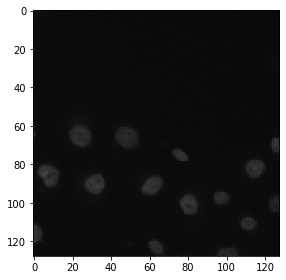

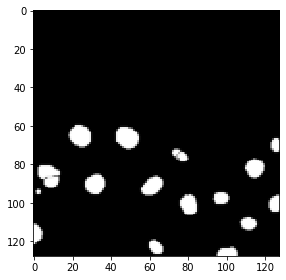

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


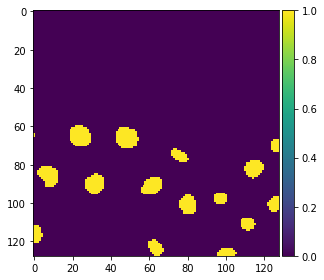

In [25]:
model = load_model('/content/model/model.h5')
predsTrain = model.predict(np.expand_dims(preProcess(xTrain[100]),axis=0))

predsThreshold = (predsTrain > 0.5).astype(np.uint8)

ix = 100
imshow(preProcess(xTrain[ix]))
plt.show()
imshow(np.squeeze(maskFormation(yTrain[ix])))
plt.show()
imshow(np.squeeze(predsThreshold))
plt.show()
